In [2]:
# imports and functions, does nothing

from IPython.display import Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from json import JSONEncoder
import json
from lib.features import *
from lib.rf import *

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def serialize(uri, o, version=''):
    try:
        os.remove(".cache/"+uri)
    except:
        pass
    with open(".cache/"+uri, "w") as f:
        if version != '':
            f.write('#version: '+version+'\n')
        json.dump(o, f, cls=NumpyArrayEncoder)

def deserialize(uri, version=''):
    if os.path.isfile(".cache/"+uri):
        with open(".cache/"+uri, "r") as f:
            data = []
            for line in f:
                if not line.startswith('#version:'):
                    data.append(line)
            return json.loads(''.join(data))
    return None

def load_or_compute(uri, compute_function, rebuild=False):
    data = None
    if not rebuild:
        data = deserialize(uri)
    if data is None:
        data = compute_function()
        serialize(uri, data)
        return data
    return data

def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""

def add(a, b):
    x = 0
    if a is not None:
        x += abs(a)
    if b is not None:
        x += abs(b)
    return x

def toOldHARFormat(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = request
                data2[url][sample].append([t, add(out_h, out_b), add(inc_h, inc_b)])
    return data2

In [5]:
data_all = np.load('datasets/quic-100p-150-40runs.npy', allow_pickle=True).item()
data = data_all['both'] # adblock + decentraleyes
urls = [url for url in data]

In [18]:
# keep only first parties

data_1st = dict()
for url in data:
    data_1st[url] = {}
    for sample in data[url]:
        data_1st[url][sample] = []
        if len(data[url][sample]) == 0:
            continue
        domain, *_ = data[url][sample][0]
        requests_1st = [request for request in data[url][sample] if request[0] == domain]
        data_1st[url][sample] = requests_1st
    print(url, len(data_1st[url]["1"]))

data_old_format = toOldHARFormat(data_1st)

tuvanun.blogspot.com 3
krdlogoped.blogspot.com 3
wewebit.com 56
pcquest.ir 23
uggsoutletofficial.com 9
inbestphotoeditors.online 42
acinq.co 4
aneukrantau30.blogspot.com 3
al7lmnews.com 5
molekmolekbelako.blogspot.com 3
youxube.com 3
ronbpost.com 1
pcdominant.com 25
japanesebrides.org 26
fling.reviews 13
cat-world.com 4
loansforbadcredit2019.com 2
paydayloansinformation.com 11
us-central1-relentlo-690aa.cloudfunctions.net 1
www.soichat.com 14
posts.google.com 1
wekuw.com 8
callvoicesupport.com 1
trevordavis.net 1
nilsonline.lk 22
tarfandgram.com 31
arti.edu.az 2
getapkapps.com 14
turkishdramas.site 7
us-central1-hearsttelevision-158321.cloudfunctions.net 1
ppdtemerlohc080.blogspot.com 2
tadalapi.com 34
sheet.new 1
uplo.us 12
gratipay.com 2
thedecorpalette.com 20
thehubflix.xyz 16
tonirovka-vidnoe24.ru 5
extratechni.blogspot.com 3
maxchadwick.xyz 3
camranhvip.com 14
smzeus.com 33
sportifytab.com 28
guestnode.com 53
crypto-engineapp.com 13
mundodrama.com 10
ign.uy 1
www.google.bf 3
us-ce

KeyError: '1'

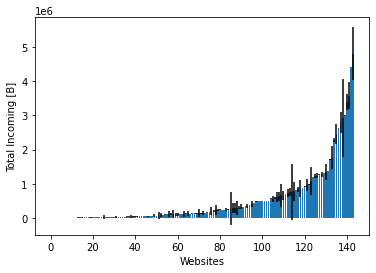

In [11]:
# total incoming size
def incoming_sizes_distrib(data):
    incoming_bytes = []
    incoming_bytes_per_website = dict()

    for url in data:
        incoming_bytes_for_this_website = []
        for sample in data[url]:
            total = 0
            for request in data[url][sample]:
                domain, fullurl, t_query, out_h, out_b, t_resp, inc_h, inc_b = request
                total += add(inc_h, inc_b)
            incoming_bytes_for_this_website.append(total)

        if len(incoming_bytes_for_this_website) > 0:
            incoming_bytes_per_website[url] =  [np.mean(incoming_bytes_for_this_website), np.std(incoming_bytes_for_this_website)]

    tuples = list(incoming_bytes_per_website.items())
    tuples.sort(key=lambda row: row[1][0])


    xs = [t[0][:3] for t in tuples]
    ys = [int(t[1][0]) for t in tuples]
    yerr = [int(t[1][1]) for t in tuples]

    plt.bar(np.arange(len(ys)), ys, yerr=yerr)
    plt.xlabel('Websites')
    plt.ylabel('Total Incoming [B]')
    #plt.yscale('log')
    #plt.ylim([0, 10000])

incoming_sizes_distrib(data_1st)

In [14]:
# how many subresources do we need to inject ?

def deepcopy(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                data2[url][sample].append(request)
    return data2

def compute_rf_performance(data):
    # baseline, no defense
    features = get_features(data)
    clf_res = rf_with_rfe(features)

    res = dict()
    res["baseline"] = dict(none=[clf_res, [0,0,0,0]])
    return res

    for p in [1]:
        for howmany in [1]:
            print(f"***************** Working on p={p}, howmany={howmany}")
            data2 = deepcopy(data)

            features = get_features(data2)
            clf_res = rf_with_rfe(features)

            print(clf_res)

            if not str(p) in res:
                res[str(p)] = dict()

            res[str(p)][str(howmany)] = [clf_res, [0,0,0,0]]

    return res

clf_res = compute_rf_performance(data_old_format)

print(clf_res)

Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping everipedia.com , 10 empty samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 141
[feature_extract] Number of features 123
[feature_extract] Number of samples 5533
[feature_extract] Number of labels 5533
Number of classes 141
Number of features 123
Number of samples 5533
Number of labels 5533
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'baseline': {'none': [{'score': {'accuracy': (0.9791327913279133, 0.0029535289474745723), 'precision': (0.9791327913279133, 0.0029535289474745723), 'recall': (0.9791327913279133, 0.0029535289474745723), 'f1score': (0.9791327913279133, 0.0029535289474745723)}, 'features': [('bytes_%_in', 0.1418361037016741, 0.004836144395146026), ('bytes_outgoing', 0.15021087150294749, 0.007026006783074291), ('bytes_total', 0.13903142132827387, 0.0037017841456277213), ('bytes_%_out', 0.13766656498650834, 0.0067929506729226515), ('bytes_incoming', 0.1

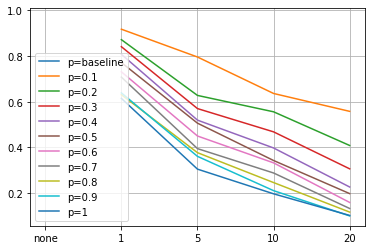

In [ ]:
plot_data = dict()

for p in clf_res:
    xs = []
    ys = []
    for howmany in clf_res[p]:
        if p=="baseline":
            continue
        xs.append(howmany)
        ys.append(clf_res[p][howmany][0]['score']['accuracy'][0])

    plt.plot(xs, ys, label=f"p={p}")
plt.legend()
plt.grid()
